# Custom Zone Models

This tutorial provides a framework for developing and testing new vadose zone and groundwater zone models.

In [1]:
%matplotlib inline
import os
import sys
from os.path import dirname
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))

from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, NonlinearReservoir
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np

/Users/nathankarst/anaconda/envs/py2k_gis/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


To instantiate a vadose or groundwater zone model, we simply need to pass in a dictionary that has as each of the required model parameters as a key. The dictionary can also have other keys. This also to use the same dictionary to instantiate both models -- each model simply takes the specific parameters it needs and ignores the rest.

In [2]:
params = {'n': 0.29, 'storage': 0, 'discharge': 0, 'groundwater': 0, 'emax': 0.5, 'b': 3, 'leakage': 0, 'a': 0.0001064, 'sfc': 0.51, 'sw': 0.3, 'zr': 76.4, 'ET': 0}

vz = PorporatoVadoseZone(**params)
gz = NonlinearReservoir(**params)

To instantiate the REW, we'll also need some forcing information. Here we'll generate synthetic rainfall data using a marked Poisson process.

In [3]:
## time domain
Tmax    = 365*5.               # days (or whatever)
dt      = 1/24.               
t       = np.linspace(0,Tmax,np.ceil(Tmax/dt))

## rainfall statistics
alpha       = 2.5               # [cm / event]
L           = 10/30.            # [events / day]

rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-L*dt) else 0.0 for i in range(len(t))])

rew = REW(vz,gz,**{'ppt':rainfall})


The critical method for both vadose and groundwater zone models is `update` which

* updates stocks in the zone
* returns a dictionary of all fluxes entering and exiting the zone; by convention, all fluxes are positive

We will assume here that each zone has a unique stock called `storage`. 

Since custom models could capture all sorts of different physical aspects of the system, we'll use the `update` method as a dummy to simply get a list of all the fluxes being modeled.

In [4]:
VzFluxHist = {}
GzFluxHist = {}

vzFluxes = rew.vz.update(dt,**{'ppt':0})
for key in vzFluxes.keys(): VzFluxHist[key] = np.zeros(np.size(t))

gzFluxes = rew.gz.update(dt,**{'leakage':0})
for key in gzFluxes.keys(): GzFluxHist[key] = np.zeros(np.size(t))        

We'll assume here that the leakage flux from the vadose zone is the only flux feeding the groundwater zone. (You might have to change this to match your custom model.)

We can test whether our vadose and groundwater zones are numerically sound by simply tracking both the total incoming water volume (here called `totalIn`, precipitation only) and the total sum of all the fluxes from the vadose and groundwater zones together with the zone stocks, `totalOut`.  Since leakage from the vadose zone to the groundwater zone is internal, we must leave it out of our mass balance book-keeping. 

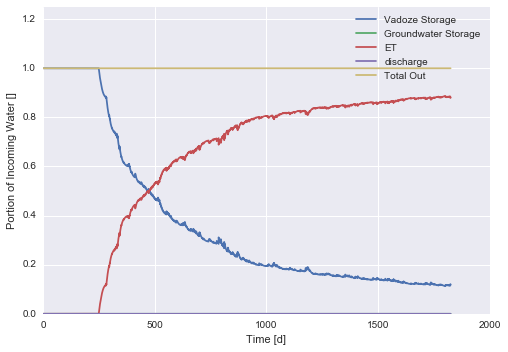

In [5]:
vzStorage   = np.zeros(np.size(t))
gzStorage   = np.zeros(np.size(t))

for i in range(len(rainfall)):
    vzFluxes = rew.vz.update(dt,**{'ppt':rew.ppt[i]})
    for key in vzFluxes.keys(): VzFluxHist[key][i] = vzFluxes.get(key,0) # [cm/d]

    vzStorage[i]    = rew.vz.storage # [cm]

    gzFluxes = rew.gz.update(dt,**{'leakage':rew.vz.leakage}) 
    for key in gzFluxes.keys(): GzFluxHist[key][i] = gzFluxes.get(key,0) # [cm/d]

    gzStorage[i]  = rew.gz.storage # [cm]

totalIn = np.cumsum(rew.ppt)*dt # [cm]

totalOut = np.zeros(np.size(t)) # [cm]

plt.plot(t,vzStorage/totalIn,label='Vadoze Storage')
plt.plot(t,gzStorage/totalIn,label='Groundwater Storage')  

totalOut += vzStorage + gzStorage

for key in VzFluxHist.keys(): 
    if key == 'leakage': continue
    cumulativeFlux = np.cumsum(VzFluxHist[key])*dt # [cm]
    plt.plot(t,cumulativeFlux/totalIn,label=key)
    totalOut += cumulativeFlux
for key in GzFluxHist.keys(): 
    cumulativeFlux = np.cumsum(GzFluxHist[key])*dt # [cm]
    plt.plot(t,cumulativeFlux/totalIn,label=key)
    totalOut += cumulativeFlux        

plt.plot(t,totalOut/totalIn,label='Total Out')
plt.ylabel('Portion of Incoming Water []')
plt.xlabel('Time [d]')
plt.legend()
plt.ylim(0,1.25)
plt.show()